# Prueba técnica

## Modelo de NLP

Lo primero es traer los datos, debido a que están en Hugging Face se traerán los datos directamente a través de la librería datasets, como lo pide el ejercicio, se trabajará con el 30% de los datos de forma aleatoria de los datos de entrenamiento.

In [1]:
import random
from datasets import load_dataset

dataset = load_dataset("alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad", split="train")
dataset = dataset.shuffle(seed=42)
n = int(0.3 * len(dataset))

# Seleccionar 30% de los datos de manera aleatoria
sample_30 = dataset.select(range(n))

print(len(sample_30))

52857


Vemos que la base de datos está compuesto del texto y su etiqueta que suponemos es la calificación del usuario, donde 5 es excelente y 1 es pésimo.

In [2]:
import pandas as pd

df = sample_30.to_pandas()
df.head(10)


,text,label
0,recuerdos de colonial. el zócalo es la plaza c...,5
1,me encanto el fuerte!. wow wow wow!!! excelent...,5
2,descansa y camina. en el corazón angelopolitan...,4
3,la mejor vista. tiene una vista fuera de serie...,5
4,la historia es aquí. qué contraste de la vieja...,4
5,museo botero bogota. lugar hermoso con muy bue...,5
6,simplemente una maravilla. una de las mejores ...,5
7,gran servicio para familias. estuvimos 5dias e...,5
8,increíble ambiente. me encantó este lugar. la ...,4
9,muy bonito. visita obligatoria al museo del or...,5


In [3]:
list(df[df["label"]==1].head(1)["text"])

['servicio de atención al cliente verdaderamente horrible!!!. viajaba como parte de una pareja por primera vez a cuba y basado en las fotografías de este hotel, decidimos reservar debido a la ubicación. yo siempre trate de leer los comentarios de otras personas con un grano de sal - comprender que las experiencias de la gente pueden variar. sin embargo, mi pareja y yo nos fastidiaron y trataron tan mal en el momento en que fuimos a la recepción del hotel para check-in. la dirección del hotel se negó a reconocer nuestra reserva en línea para dos personas y dos camas dobles y el gerente realmente le contesté diciendo que era "nuestro problema, y que deberíamos esperar este cuando viaje internacionalmente. "nosotros nos avergonzó y absolutamente vergüenza en frente de otras personas. nos alojamos una noche, pero incluso entonces, dos hombres…']

Al revisar los datos, vemos que están desbalanceados a favor de los comentarios positivos por lo que más adelante aplicaremos métodos de balanceo. Por ahora, y para simplificar el modelo diremos que los comentarios con calificación entre 5 y 4 serán positivos (1) y menores a 4 serán negativos (0).

In [4]:
df.groupby("label").size()

label
1     1196
2     1471
3     4593
4    12608
5    32989
dtype: int64

In [5]:
import numpy as np
df["sentimiento"] = np.where(df["label"] <= 3, 0, 1)
df.head(10)

,text,label,sentimiento
0,recuerdos de colonial. el zócalo es la plaza c...,5,1
1,me encanto el fuerte!. wow wow wow!!! excelent...,5,1
2,descansa y camina. en el corazón angelopolitan...,4,1
3,la mejor vista. tiene una vista fuera de serie...,5,1
4,la historia es aquí. qué contraste de la vieja...,4,1
5,museo botero bogota. lugar hermoso con muy bue...,5,1
6,simplemente una maravilla. una de las mejores ...,5,1
7,gran servicio para familias. estuvimos 5dias e...,5,1
8,increíble ambiente. me encantó este lugar. la ...,4,1
9,muy bonito. visita obligatoria al museo del or...,5,1


Procedemos ahora a hacer limpieza de los datos

In [6]:
import re
import nltk
#nltk.download()
import string
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("spanish")
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

def processCleanData(text):
    # changing to lower case
    text = text.lower()
    # removing symbols
    text = re.sub(r'@\S+', '', text)
    # removing links
    text = re.sub(r'http\S+', '', text)
    # removing pictures
    text = re.sub(r'.pic\S+', '', text)
    # removing other characters excpet text
    text = re.sub(r'[^a-zA-Z+]', ' ', text)
    # removing punctuation
    # getting punctuation list of string.punctation
    text = "".join([char for char in text if char not in string.punctuation])
    # tokenizing the words
    words = nltk.word_tokenize(text, language='spanish')
    # using Lancaster stemmer to step the words
    # example eating eater becones eat
    words = list(map(lambda x: stemmer.stem(x), words))
    # removing and joining the stop words
    text = " ".join([char for char in words if char not in stop_words and len(char) > 2])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/megakaos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df["texto limpio"] = df["text"].apply(processCleanData)

Limpiados los datos los balancearemos, por tiempo, y debido a que tenemos más de 7000 muestras negativas vamos a tomar el mismo número de muestras positivas para dejar los datos balanceados (50/50).

In [8]:
df_clean=df[["texto limpio","sentimiento"]]

In [9]:
df_clean.groupby("sentimiento").size()

sentimiento
0     7260
1    45597
dtype: int64

In [10]:
from sklearn.utils import resample

df_neg = df_clean[df_clean["sentimiento"] == 0]
df_pos = df_clean[df_clean["sentimiento"] == 1]
df_pos_down = resample(df_pos, replace=False, n_samples=len(df_neg), random_state=42)
df_balanced = pd.concat([df_neg, df_pos_down]).sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
df_balanced

,texto limpio,sentimiento
0,vacacion famili dud voy content hotel com ric ...,1
1,recom nadi ser nic interes ubicaci caden tryp ...,0
2,cub mejor restaur exist havan cub sazon servic...,1
3,castill san felip baraj interes tour trav cast...,1
4,vist herm par sub taquill hac fil compr tiquet...,1
...,...,...
14515,pobr tod est viej pobr tien acces adecu intern...,0
14516,pase medell impresion sistem integr transport ...,1
14517,mejor anterior aloj tres vec vle durant estanc...,0
14518,cre espect cul canon val pen cuc billet par cl...,0


Se prueban diferentes modelos, para el caso de SVM y Random Forest se usa un RandomGrid limitado por temas de tiempo.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pickle

## modelo Naive Bayes 
def useMultinominalNB(xTrain, yTrain, xTest, yTest):
    startTime =time.time()
    model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    model.fit(xTrain, yTrain)
    ypred = model.predict(xTest)
    endTime = time.time()
    elapsedTime = endTime-startTime
    cm = confusion_matrix(yTest,ypred)
    accuracy = accuracy_score(ypred, yTest)
    precision = precision_score(yTest,ypred)
    recall = recall_score(yTest,ypred)
    reportSample = {
        'algorithm': 'MultiNominal NaiveBayes',
        'timeTaken': elapsedTime,
        'accuracy': round(accuracy*100,3),
        'precision': round(precision,3),
        'recall': round(recall,3)
    }
    allReport.append(reportSample)

    sns.heatmap(cm,annot=True, fmt='d')
    plt.xlabel('True Values negativo = 0 | positivo = 1')
    plt.ylabel('Predicted Values')
    plt.title('matriz de confusión  NB')
    plt.show()
    pickle.dump(model,open(f"models/{allModel.get('nb','model')}",'wb'))
    return accuracy

In [13]:
# Modelo SVM
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

def useSVCGridSearch(xTrain,yTrain,xTest,yTest):
    startTime = time.time()
    pipe = make_pipeline(TfidfVectorizer(), SVC())
    param_grid = {
        'svc__degree': [2, 3, 4, 5],
        'svc__gamma': [0.001, 0.01, 0.1],
        'svc__C': [0.001, 0.01, 0.1, 1]
    }

    grid = RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, n_iter=10, n_jobs=-1)
    grid.fit(xTrain, yTrain)
    model = grid.best_estimator_
    print(grid.best_score_)
    model.fit(xTrain,yTrain)
    ypred = model.predict(xTest)
    endTime = time.time()
    elapsed = endTime-startTime
    accuracy = accuracy_score(ypred, yTest)
    precision = precision_score(yTest, ypred)
    recall = recall_score(yTest, ypred)
    reportSample = {
        'algorithm': 'SVM With Grid Search',
        'timeTaken': elapsed,
        'accuracy': round(accuracy * 100, 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3)
    }
    allReport.append(reportSample)

    cm = confusion_matrix(yTest, ypred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('True Values negativo = 0 | positivo = 1')
    plt.ylabel('Predicted Values')
    plt.title('matriz de confusión  SVC')
    plt.show()
    pickle.dump(model,open(f"models/{allModel.get('svc','model2')}",'wb'))
    return accuracy

In [20]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

def useRandomGridSearch(xTrain,yTrain,xTest,yTest):
    startTime=time.time()
    pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
    param_grid = {
        'randomforestclassifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'randomforestclassifier__max_depth': [None, 10, 20, 30],  # Depth of each tree
        'randomforestclassifier__min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
        'randomforestclassifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be a leaf node
    }

    grid = RandomizedSearchCV(pipe,param_distributions=param_grid,cv=5, n_iter=8, n_jobs=-1)
    grid.fit(xTrain, yTrain)
    model = grid.best_estimator_
    print(grid.best_score_)
    model.fit(xTrain,yTrain)
    ypred = model.predict(xTest)
    endTime = time.time()
    elapsed = endTime - startTime
    accuracy = accuracy_score(ypred, yTest)
    precision = precision_score(yTest, ypred)
    recall = recall_score(yTest, ypred)
    reportSample = {
        'algorithm': 'RandomForest With Grid',
        'timeTaken': elapsed,
        'accuracy': round(accuracy * 100, 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3)
    }
    allReport.append(reportSample)
    cm = confusion_matrix(yTest, ypred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('True Values negativo = 0 | positivo = 1')
    plt.ylabel('Predicted Values')
    plt.title('matriz de confusión  Random Forest')
    plt.show()
    pickle.dump(model,open(f"models/{allModel.get('rf','model2')}",'wb'))
    return accuracy

In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

def useLogisticRegression(xTrain,yTrain,xTest,yTest):
    startTime =time.time()
    model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
    model.fit(xTrain, yTrain)
    ypred = model.predict(xTest)
    endTime = time.time()
    elapsed = endTime - startTime
    accuracy = accuracy_score(ypred, yTest)
    precision = precision_score(yTest, ypred)
    recall = recall_score(yTest, ypred)
    reportSample = {
        'algorithm': 'Logistic',
        'timeTaken': elapsed,
        'accuracy': round(accuracy * 100, 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3)
    }
    allReport.append(reportSample)
    accuracy = accuracy_score(ypred, yTest)
    cm = confusion_matrix(yTest, ypred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('True Values negativo = 0 | positivo = 1')
    plt.ylabel('Predicted Values')
    plt.title('matriz de confusión Logistic Regression')
    plt.show()
    pickle.dump(model,open(f"models/{allModel.get('lr','model2')}",'wb'))
    return accuracy

In [16]:
df_balanced.columns

Index(['texto limpio', 'sentimiento'], dtype='object')

Como podemos ver en la tabla, los mejores resultados corresponden a los modelos logístico y SVM. Sin embargo, es de aclarar que es probable un mejoría en los resultados si se prueban más configuraciones de los hiperparámetros.

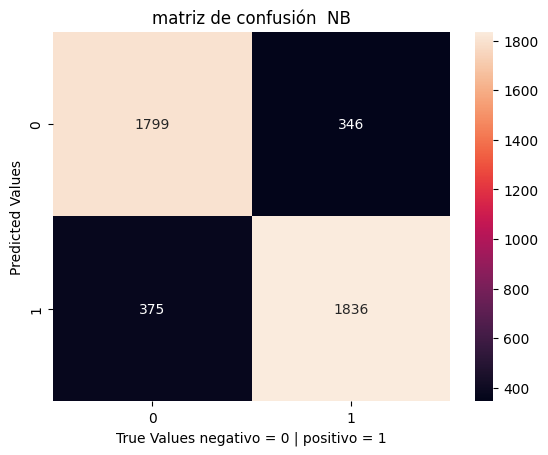

Accuracy Multinominal NB 83%


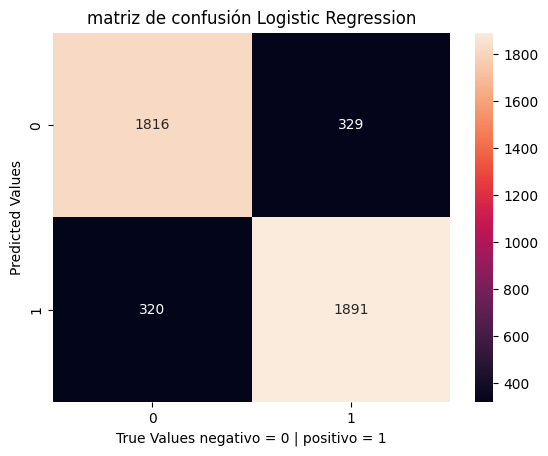

Accuracy Logistic Regression  85%
0.8426806124148403


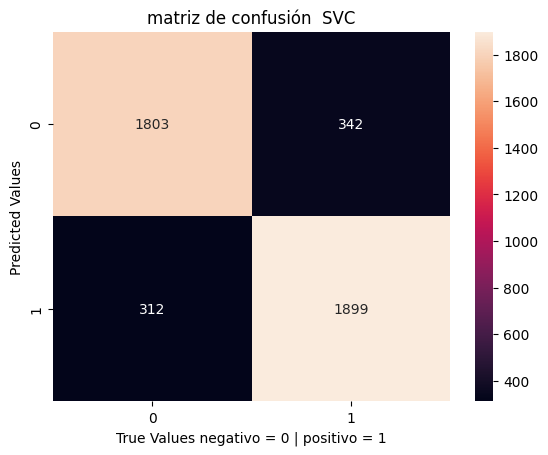

Accuracy SVC  85%
0.8211341603696489


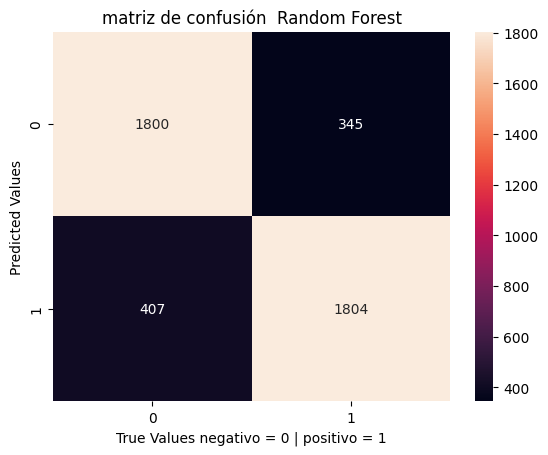

Accuracy Random Forest  83%
            Algorithm Name  Time Taken (seconds)  Accuracy  Precision  Recall
0  MultiNominal NaiveBayes              0.381238    83.448      0.841   0.830
1        SVM With Logistic              3.039817    85.101      0.852   0.855
2     SVM With Grid Search            433.468179    84.986      0.847   0.859
3   RandomForest With Grid             40.222663    82.736      0.839   0.816


In [26]:
X = df_balanced['texto limpio']
y = df_balanced['sentimiento']

xTrain, xTest, yTrain, yTest = train_test_split(X, y, train_size=0.7, random_state=42)
allReport=[]
allModel = {
    "lr": "modelo_logistic_regression.pkl",
    "rf": "modelo_random_forest.pkl",
    "svc": "modelo_svm.pkl",
    "nb": "modelo_naive_bayes.pkl"
}

print(f'Accuracy Multinominal NB {round(useMultinominalNB(xTrain, yTrain, xTest, yTest) * 100)}%')
print(f'Accuracy Logistic Regression  {round(useLogisticRegression(xTrain, yTrain, xTest, yTest) * 100)}%')
print(f'Accuracy SVC  {round(useSVCGridSearch(xTrain, yTrain, xTest, yTest) * 100)}%')
print(f'Accuracy Random Forest  {round(useRandomGridSearch(xTrain, yTrain, xTest, yTest) * 100)}%')

#Creating a final report for the algorithms above
finalReportData = pd.DataFrame(allReport)
finalReportData.columns = ['Algorithm Name','Time Taken (seconds)','Accuracy','Precision','Recall']
print(finalReportData)

In [22]:
lr_loaded = pickle.load(open(f"models/{allModel['lr']}", "rb"))
rf_loaded = pickle.load(open(f"models/{allModel['rf']}", "rb"))
svc_loaded = pickle.load(open(f"models/{allModel['svc']}", "rb"))
nb_loaded = pickle.load(open(f"models/{allModel['nb']}", "rb"))


Finalmente, realizamos el testeo con unos textos creados manualmente para probar los modelos. En general se predice bien a excepción del modelo de Random Forest donde el comentario negativo lo toma como positivo.

In [28]:
def predictData(dataToPredict,model):
    dataToPredictCleaned = list(map(processCleanData,dataToPredict))
    model = pickle.load(open(f'models/{model}', "rb"))
    predicted = model.predict(dataToPredictCleaned)
    print(predicted)


dataToPredict = ["La mejor experiencia que he tenido en mi vida","Una porquería de cervisio"]

print("Resultado del modelo logístico",predictData(dataToPredict,allModel.get('lr')))
print("Resultado del modelo Random Forest", predictData(dataToPredict,allModel.get('rf')))
print("Resultado del modelo SVM", predictData(dataToPredict,allModel.get('svc')))
print("Resultado del modelo Naive Bayes", predictData(dataToPredict,allModel.get('nb')))

[1 0]
Resultado del modelo logístico None
[1 1]
Resultado del modelo Random Forest None
[1 0]
Resultado del modelo SVM None
[1 0]
Resultado del modelo Naive Bayes None
